Using Euler time stepping

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import PyCO2SYS as pyco2
import xarray as xr
from datetime import datetime
from scipy.optimize import minimize

In [51]:
# directories
rawDir = "../data/raw/"
interimDir = "../data/interim/"
processedDir = "../data/processed/"
imgDir = "../img/"

In [ ]:
# --- Parameters from the paper (GB site) ---
params = {
    'T1_star': 9.51, # °C
    'T2_star': 10.00, # °C
    'S1_star': 32.47, # psu
    'S2_star': 32.44, # psu
    'A_1T': 9.00, # °C
    'A_1S': -0.75, # psu
    'A_2T': 3.50, # °C
    'phi_1T': -0.97, # radians
    'phi_1S': -0.45, # radians
    'phi_2T': -1.54, # radians
    'tau_1T': 0.09, # yr
    'tau_1S': 0.27, # yr
    'tau_2': 0.15, # yr
    'KD': 1e-5, # we need it in m^2/yr!
    'NPP': 1.0, # gC/m2^/day needs to be converted to m*µmolC/kg/yr
    'Fratio': 0.25, # unitless ?
    'PICPOC': 0.04, # unitless ?
    'Remin': 1.0, # unitless ?
    'h1': 25.0, # m
    'h2': 45.0 # m
}

NCP = params['NPP'] * params['Fratio']
# pCO2_atm is the atmospheric partial pressure of CO2
pCO2_atm = 420  # in µatm
# K_air is the gas transfer velocity calculated as in Wanninkhof [3] with a seasonally variable wind speed determined from the nearest NDBC monitoring buoy (GB, Station 44011; MA, Station 44009)
K_air = 0.251  # we need it in m/yr!

delta_z = (params["h1"] + params["h2"])/2

In [53]:
# --- Initial Conditions (GB site) ---
initial_state = np.array([
    23.29,  # T1
    8.52,   # T2
    31.67,  # S1
    32.95,  # S2
    1890.1, # DIC1
    2019.0, # DIC2
    2160.6, # TA1
    2125.7  # TA2
])


# Norwegen Werte

In [ ]:
params = {
    'T1_star': 8.9, # °C
    'T2_star': 8.3, # °C
    'S1_star': 35.1, # psu
    'S2_star': 35.1, # psu
    'A_1T': 3.50, # °C
    'A_1S': -0.3, # psu
    'A_2T': 2.5, # °C
    'phi_1T': -0.97, # radians
    'phi_1S': -0.45, # radians
    'phi_2T': -1.54, # radians
    'tau_1T': 0.09, # yr
    'tau_1S': 0.27, # yr
    'tau_2': 0.15, # yr
    'KD': 1e-5, # we need it in m^2/yr!
    'NPP': 1.0, # gC/m2^/day needs to be converted to m*µmolC/kg/yr
    'Fratio': 0.25, # unitless ?
    'PICPOC': 0.04, # unitless 
    'Remin': 1.0, # unitless ?
    'h1': 25.0, # m
    'h2': 45.0 # m
}

NCP = params['NPP'] * params['Fratio']
# pCO2_atm is the atmospheric partial pressure of CO2
pCO2_atm = 420  # in µatm
# K_air is the gas transfer velocity calculated as in Wanninkhof [3] with a seasonally variable wind speed determined from the nearest NDBC monitoring buoy (GB, Station 44011; MA, Station 44009)
K_air = 0.251  # we need it in m/yr!

delta_z = (params["h1"] + params["h2"])/2

In [161]:
# --- Initial Conditions (GB site) ---
initial_state = np.array([
    8,  # T1
    8,   # T2
    35.1,  # S1
    35.1,  # S2
    1890.1, # DIC1
    2019.0, # DIC2
    2160.6, # TA1
    2125.7  # TA2
])

In [162]:
# --- Simulation Settings ---
dt = 0.1  # years
total_time = 10  # years
nt = int(total_time / dt) # number of time steps
times = np.linspace(0, total_time, nt + 1)

In [ ]:
# --- Density Function (linear approximation) 
#If Δ𝜌>0 surface water is denser → convection occurs.

#IfΔ𝜌<0 surface water is lighter → no convection.

def density(T1, T2, S1, S2):
    alpha = 0.2 # thermal expansion coefficient 
    beta = 0.8 # haline contraction coefficient
    return alpha * (T2 - T1) + beta * (S2 - S1)

In [ ]:
# --- Initialize output ---
state = initial_state.copy()
states = [state.copy()]
pH_values = []
pCO2_surf_values = []
J_air_values = []


# --- Euler Integration Loop ---
for t in times[1:]:
    T1, T2, S1, S2, DIC1, DIC2, TA1, TA2 = state # units °C, psu, µmol/kg, µmol/kg
    p = params

    # Seasonal Forcing Terms
    seasonal_T1 = p['A_1T'] * np.cos(2 * np.pi * t + p['phi_1T']) # °C
    seasonal_T2 = p['A_2T'] * np.cos(2 * np.pi * t + p['phi_2T']) # °C
    seasonal_S1 = p['A_1S'] * np.cos(2 * np.pi * t + p['phi_1S']) # psu

    # Derivatives
    dT1 = (p['T1_star'] - seasonal_T1 - T1) / p['tau_1T'] # °C/yr
    dT2 = (p['T2_star'] - seasonal_T2 - T2) / p['tau_2'] # °C/yr
    dS1 = (p['S1_star'] - seasonal_S1 - S1) / p['tau_1S'] # psu/yr
    dS2 = (p['S2_star'] - S2) / p['tau_2']

    # Calculate pCO2surf using PyCO2SYS
    co2sys_result = pyco2.sys(
    par1=TA1,
    par2=DIC1,
    par1_type=1,  # 1 = TA
    par2_type=2,  # 2 = DIC
    salinity=S1,
    temperature=T1,
    pressure=0,  # sea surface pressure, in dbar

    total_silicate=0.0,     # explicitly zero
    total_phosphate=0.0,    # explicitly zero

    opt_k_carbonic=4,       # 4 = Mehrbach refit by Dickson & Millero (2007)
    opt_k_bisulfate=1,      # 1 = Dickson (1990)
    )

    pCO2_surf = co2sys_result['pCO2'] # µatm
    pCO2_surf_values.append(pCO2_surf)

    pH = co2sys_result['pH'] 
    pH_values.append(pH)
    # alpha_CO2 is the CO2 solubility calculated as in Weiss [4]
    alpha_CO2 = co2sys_result["k_CO2"]  # This gives CO₂ solubility we need µmol/kg*µatm!!!!

    # CO2 flux (positive into ocean)
    J_air = K_air * alpha_CO2 * (pCO2_atm - pCO2_surf) # m*µmol/kg/yr
    J_air_values.append(J_air)

    dDIC1 = (J_air + p['KD'] * ((DIC2 - DIC1) / delta_z) - NCP * (1 + p['PICPOC'])) / p['h1'] # µmol/kg/yr
    dDIC2 = (p['Remin'] * NCP + NCP * p['PICPOC'] - p['KD'] * ((DIC2 - DIC1) / delta_z)) / p['h2'] # µmol/kg/yr
    dTA1 = (p['KD'] * ((TA2 - TA1) / delta_z) - 2 * NCP * p['PICPOC']) / p['h1'] # µmol/kg/yr
    dTA2 = (-p['KD'] * ((TA2 - TA1) / delta_z) + 2 * NCP * p['PICPOC']) / p['h2'] # µmol/kg/yr

    # Tentative Euler Step
    T1_hat = T1 + dt * dT1 # °C
    T2_hat = T2 + dt * dT2 # °C
    S1_hat = S1 + dt * dS1 # psu
    S2_hat = S2 + dt * dS2 # psu
    DIC1_hat = DIC1 + dt * dDIC1 # µmol/kg
    DIC2_hat = DIC2 + dt * dDIC2 # µmol/kg
    TA1_hat = TA1 + dt * dTA1   # µmol/kg
    TA2_hat = TA2 + dt * dTA2  # µmol/kg

    # Potential Density Mixing Condition
    if density(T1_hat,T2_hat, S1_hat, S2_hat) > 0:
        mix_T = (p['h1'] * T1_hat + p['h2'] * T2_hat) / (p['h1'] + p['h2']) # °C
        mix_S = (p['h1'] * S1_hat + p['h2'] * S2_hat) / (p['h1'] + p['h2']) # psu
        mix_DIC = (p['h1'] * DIC1_hat + p['h2'] * DIC2_hat) / (p['h1'] + p['h2']) # µmol/kg
        mix_TA = (p['h1'] * TA1_hat + p['h2'] * TA2_hat) / (p['h1'] + p['h2'])  # µmol/kg
        state = np.array([mix_T, mix_T, mix_S, mix_S, mix_DIC, mix_DIC, mix_TA, mix_TA])
    else:
        state = np.array([T1_hat, T2_hat, S1_hat, S2_hat, DIC1_hat, DIC2_hat, TA1_hat, TA2_hat])

    states.append(state.copy())

    #state = np.array([T1_hat, T2_hat, S1_hat, S2_hat, DIC1_hat, DIC2_hat, TA1_hat, TA2_hat])
    #states.append(state.copy())


# --- Save Results ---
columns = ['T1', 'T2', 'S1', 'S2', 'DIC1', 'DIC2', 'TA1', 'TA2']
df = pd.DataFrame(states, columns=columns)
df['time'] = times

# Add a starting dummy value to match length
pH_values.insert(0, np.nan)
pCO2_surf_values.insert(0, np.nan)
J_air_values.insert(0, np.nan)

# Add to dataframe
df['pH'] = pH_values
df['pCO2_surf'] = pCO2_surf_values
df['J_air'] = J_air_values

# Save to CSV
df.to_csv(processedDir + "GB_model_output.csv", index=False)

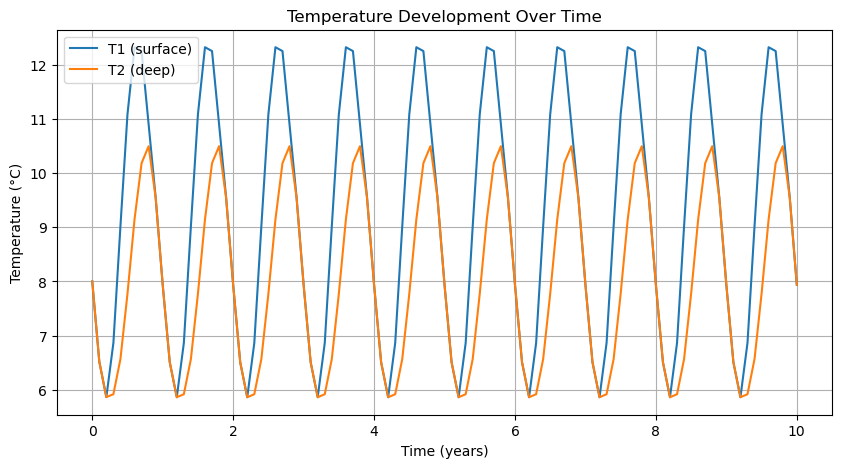

In [165]:
# --- Plotting: Temperature ---
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['T1'], label='T1 (surface)')
plt.plot(df['time'], df['T2'], label='T2 (deep)')
plt.xlabel('Time (years)')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Development Over Time')
plt.legend()
plt.grid(True)
plt.savefig(imgDir + "model_temperature_development_neu.png", dpi=300)
plt.show()

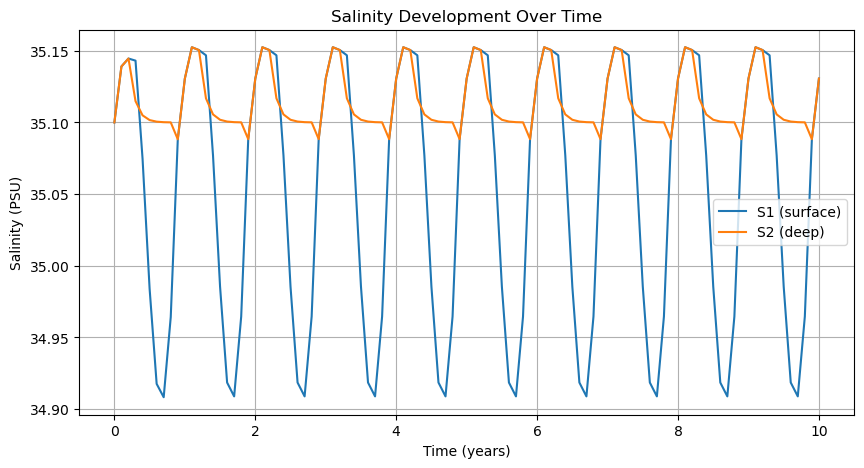

In [166]:
# --- Plotting: Salinity ---
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['S1'], label='S1 (surface)')
plt.plot(df['time'], df['S2'], label='S2 (deep)')
plt.xlabel('Time (years)')
plt.ylabel('Salinity (PSU)')
plt.title('Salinity Development Over Time')
plt.legend()
plt.grid(True)
plt.savefig(imgDir + "model_salinity_development_neu.png", dpi=300)
plt.show()

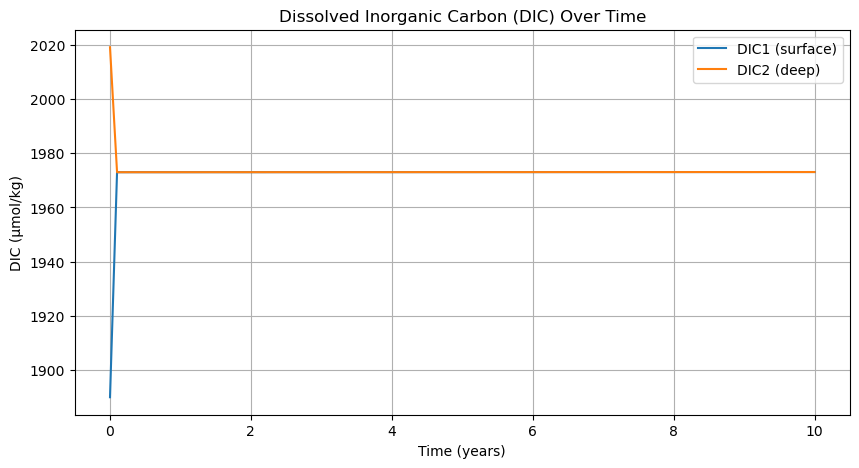

In [167]:
# --- Plotting: Disolved Inorganic Carbon ---
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['DIC1'], label='DIC1 (surface)')
plt.plot(df['time'], df['DIC2'], label='DIC2 (deep)')
plt.xlabel('Time (years)')
plt.ylabel('DIC (µmol/kg)')
plt.title('Dissolved Inorganic Carbon (DIC) Over Time')
plt.legend()
plt.grid(True)
plt.savefig(imgDir + "model_DIC_development_neu.png", dpi=300)
plt.show()


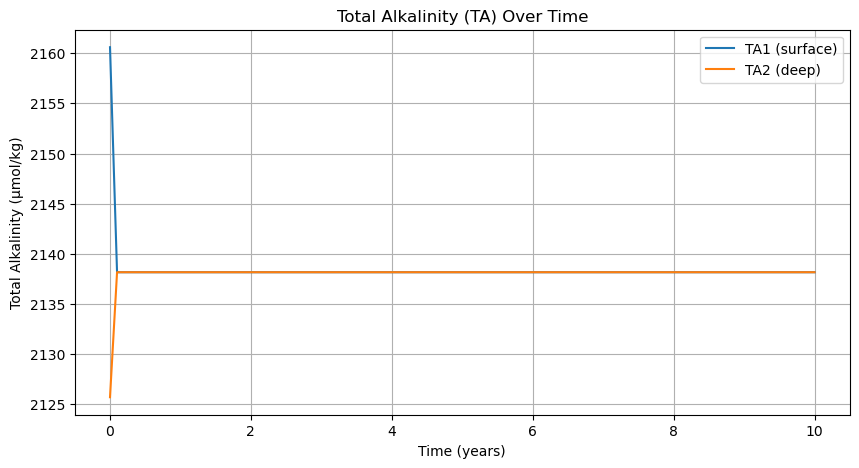

In [168]:
# --- Plotting: Alkalinity ---
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['TA1'], label='TA1 (surface)')
plt.plot(df['time'], df['TA2'], label='TA2 (deep)')
plt.xlabel('Time (years)')
plt.ylabel('Total Alkalinity (µmol/kg)')
plt.title('Total Alkalinity (TA) Over Time')
plt.legend()
plt.grid(True)
plt.savefig(imgDir + "model_TA_development_neu.png", dpi=300)
plt.show()


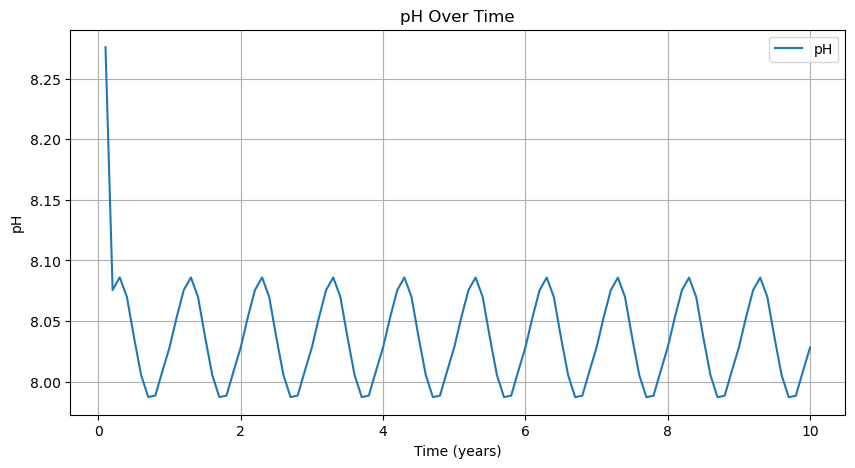

In [169]:
# --- Plotting: pH ---
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['pH'], label='pH')
plt.xlabel('Time (years)')
plt.ylabel('pH')
plt.title('pH Over Time')
plt.legend()
plt.grid(True)
plt.savefig(imgDir + "model_pH_development_neu.png", dpi=300)
plt.show()

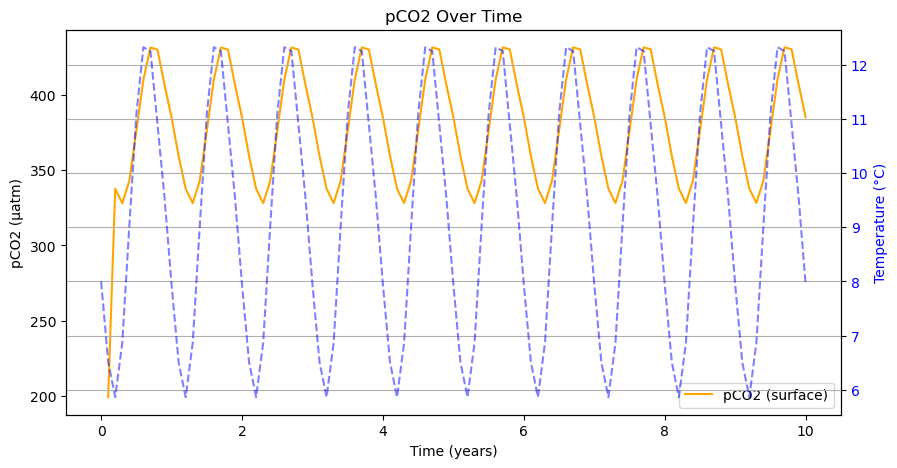

In [170]:
# --- Plotting: pCO2 ---
plt.figure(figsize=(10, 5))
# plot temperature
#plt.plot(df['time'], df['T1'], label='T1 (surface)', color='blue')
plt.plot(df['time'], df['pCO2_surf'], label='pCO2 (surface)', color='orange')
plt.xlabel('Time (years)')
plt.ylabel('pCO2 (µatm)')
plt.title('pCO2 Over Time')
plt.legend()
# second axis for temperature
ax2 = plt.gca().twinx()
ax2.set_ylabel('Temperature (°C)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
plt.plot(df['time'], df['T1'], color='blue', linestyle='--', alpha=0.5)
plt.grid(True)
plt.savefig(imgDir + "model_pCO2_development_neu.png", dpi=300)
plt.show()

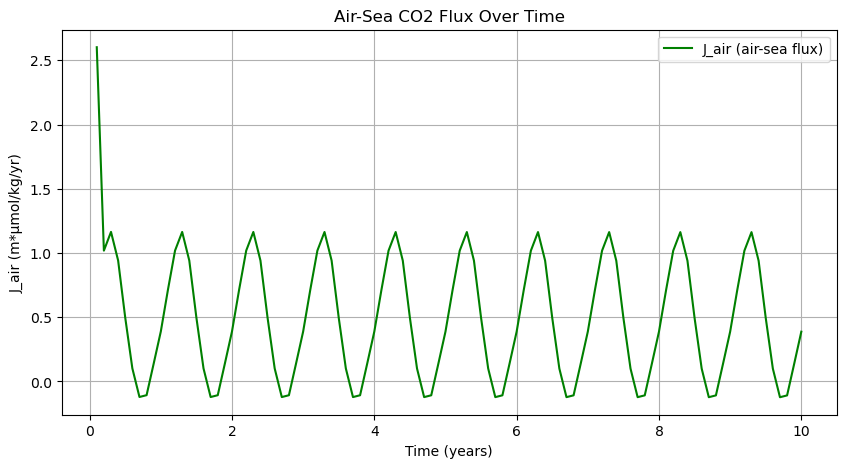

In [171]:
# --- Plotting: J_air ---
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['J_air'], label='J_air (air-sea flux)', color='green')
plt.xlabel('Time (years)')
plt.ylabel('J_air (m*µmol/kg/yr)')
plt.title('Air-Sea CO2 Flux Over Time')
plt.legend()
plt.grid(True)
plt.savefig(imgDir + "model_J_air_development.png", dpi=300)
plt.show()

# Compare to SOCAT data

In [172]:
# Open the dataset
socat_data = xr.open_dataset(rawDir + "SOCATv2024_tracks_gridded_monthly.nc")

# List all variables
print("Variables:\n", list(socat_data.data_vars))

Variables:
 ['tmnth_bnds', 'count_ncruise', 'fco2_count_nobs', 'fco2_ave_weighted', 'fco2_ave_unwtd', 'fco2_min_unwtd', 'fco2_max_unwtd', 'fco2_std_weighted', 'fco2_std_unwtd', 'sst_count_nobs', 'sst_ave_weighted', 'sst_ave_unwtd', 'sst_min_unwtd', 'sst_max_unwtd', 'sst_std_weighted', 'sst_std_unwtd', 'salinity_count_nobs', 'salinity_ave_weighted', 'salinity_ave_unwtd', 'salinity_min_unwtd', 'salinity_max_unwtd', 'salinity_std_weighted', 'salinity_std_unwtd', 'lat_offset_unwtd', 'lon_offset_unwtd']


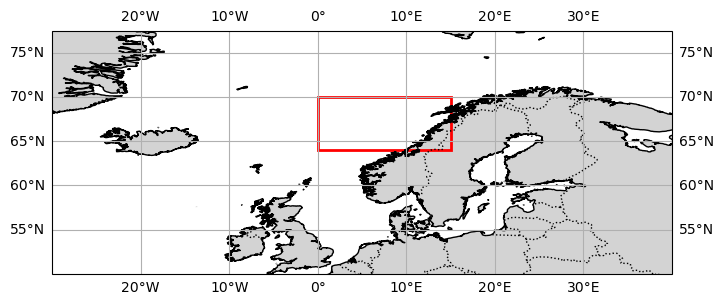

In [173]:
# --- Define your lat/lon extent ---
lat_min, lat_max = 64, 70 # 60,68
lon_min, lon_max = 0, 15

# --- Create a map ---
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add coastlines and features
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.set_extent([-30, 40, 50, 75])  # wider map view around area

# --- Add rectangle for your lat/lon range ---
rect = Rectangle(
    (lon_min, lat_min),             # lower-left corner
    lon_max - lon_min,              # width (in degrees)
    lat_max - lat_min,              # height (in degrees)
    linewidth=2,
    edgecolor='red',
    facecolor='none',
    transform=ccrs.PlateCarree()
)

ax.add_patch(rect)
ax.gridlines(draw_labels=True)
plt.show()


In [174]:
lat_range = slice(lat_min, lat_max) 
lon_range = slice(lon_min, lon_max) 
year_min = 2010
year_max = 2019 

# Extract relevant variables and region
norway_data = socat_data[[
    'sst_ave_weighted', 
    'salinity_ave_weighted', 
    'fco2_ave_weighted'
]].sel(ylat=lat_range, xlon=lon_range)


# Filter time range from 2010 to 2020
start_date = f"{year_min}-01-01"
end_date = f"{year_max}-12-31"
norway_data = norway_data.sel(tmnth=slice(start_date, end_date))
area_mean = norway_data.mean(dim=['xlon', 'ylat'], skipna=True)


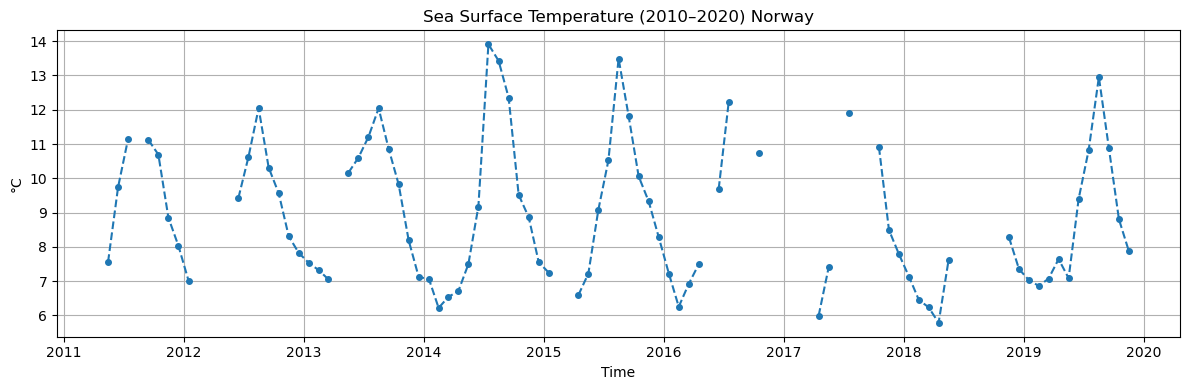

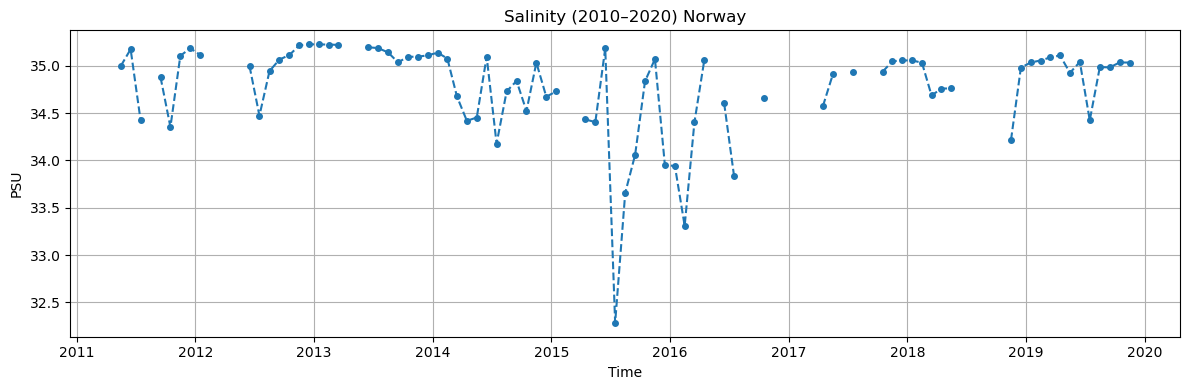

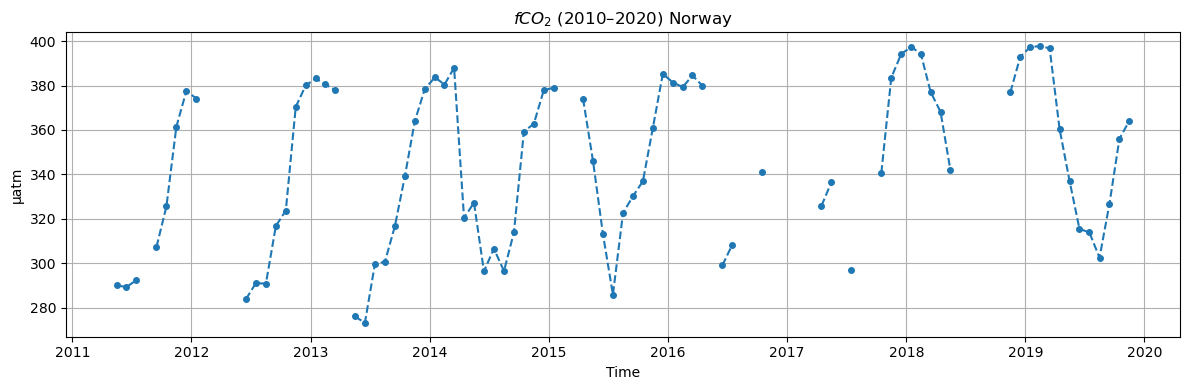

In [231]:
# Plot time series for each variable
def plot_time_series(var, label, ylabel):
    plt.figure(figsize=(12, 4))
    plt.plot(area_mean.tmnth, area_mean[var], label=label, linestyle='--', marker='o', markersize=4)
    plt.title(f"{label} (2010–2020) Norway")
    plt.xlabel("Time")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(imgDir + f"{var}_time_series.png", dpi=300)
    plt.show()

# Plot each variable
plot_time_series('sst_ave_weighted', 'Sea Surface Temperature', '°C')
plot_time_series('salinity_ave_weighted', 'Salinity', 'PSU')
plot_time_series('fco2_ave_weighted', r'$fCO_2$', 'µatm')

### Prepare Observational data 1 value per month (area, monthly mean)

In [176]:
monthly_mean = area_mean.resample(tmnth='1MS').mean()

# Convert area mean to pandas DataFrame
obs_mean_df = monthly_mean.to_dataframe().reset_index()

# Rename for consistency
obs_mean_df = obs_mean_df.rename(columns={
    'tmnth': 'date_obs',
    'sst_ave_weighted': 'T1_obs',
    'salinity_ave_weighted': 'S1_obs',
    'fco2_ave_weighted': 'pCO2_obs'
})

print(obs_mean_df.head())

    date_obs  T1_obs  S1_obs  pCO2_obs
0 2010-01-01     NaN     NaN       NaN
1 2010-02-01     NaN     NaN       NaN
2 2010-03-01     NaN     NaN       NaN
3 2010-04-01     NaN     NaN       NaN
4 2010-05-01     NaN     NaN       NaN


### Prepare Model data 1 value per month

In [177]:
# Base time for your model (e.g. Jan 1, 2010)
start_year = datetime(2010, 1, 1)

# Convert model time in fractional years to actual dates
df['date'] = pd.to_datetime(df['time'] * 365.25, unit='D', origin=start_year)

df['date'] = df['date'].dt.to_period('M').dt.to_timestamp()

print(df.head(7))

          T1        T2         S1         S2         DIC1         DIC2  \
0   8.000000  8.000000  35.100000  35.100000  1890.100000  2019.000000   
1   6.520952  6.520952  35.139053  35.139053  1972.968002  1972.968002   
2   5.866545  5.866545  35.144608  35.144608  1972.969457  1972.969457   
3   6.865506  5.920364  35.143134  35.114869  1972.973074  1972.970035   
4   9.019038  6.569128  35.074624  35.104956  1972.975802  1972.970613   
5  11.085161  7.774362  34.983973  35.101652  1972.976749  1972.971190   
6  12.321287  9.145483  34.917596  35.100551  1972.976117  1972.971768   

           TA1          TA2  time        pH   pCO2_surf     J_air       date  
0  2160.600000  2125.700000   0.0       NaN         NaN       NaN 2010-01-01  
1  2138.164286  2138.164286   0.1  8.275905  199.001516  2.601645 2010-02-01  
2  2138.164286  2138.164286   0.2  8.075633  337.789855  1.018371 2010-03-01  
3  2138.164206  2138.164330   0.3  8.086064  328.147649  1.164303 2010-04-01  
4  2138.1641

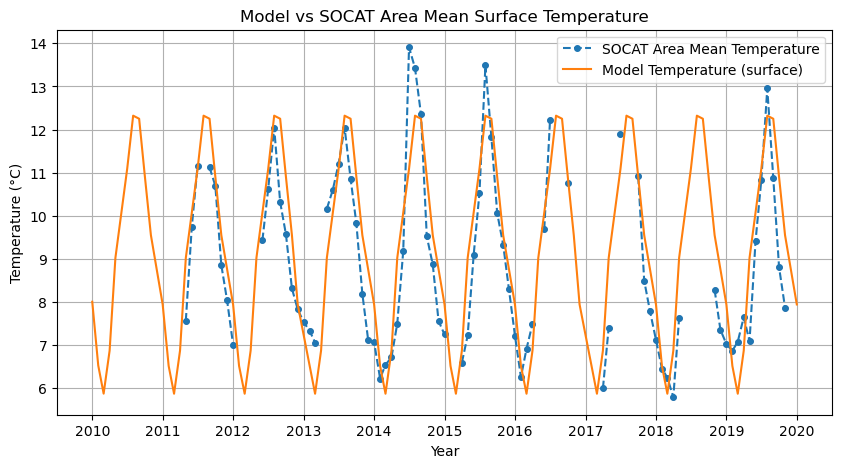

In [228]:
plt.figure(figsize=(10, 5))
plt.plot(obs_mean_df['date_obs'], obs_mean_df['T1_obs'], label='SOCAT Area Mean Temperature', linestyle='--', marker='o', markersize=4)
plt.plot(df['date'], df['T1'], label='Model Temperature (surface)')
plt.scatter(obs_mean_df['date_obs'], obs_mean_df['T1_obs'], s=10, color='red')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('Model vs SOCAT Area Mean Surface Temperature')
plt.grid(True)
plt.legend()
plt.savefig(imgDir + "GB_model_vs_SOCAT_Temperature.png", dpi=300)
plt.show()


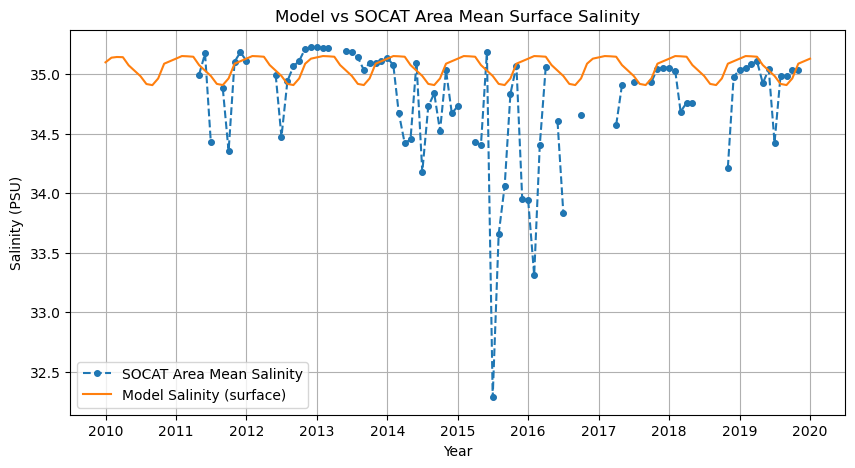

In [229]:
plt.figure(figsize=(10 ,5))
plt.plot(obs_mean_df['date_obs'], obs_mean_df['S1_obs'], label='SOCAT Area Mean Salinity', linestyle='--', marker='o', markersize=4)
plt.plot(df['date'], df['S1'], label='Model Salinity (surface)')
plt.scatter(obs_mean_df['date_obs'], obs_mean_df['S1_obs'], s=10, color='red')  
plt.xlabel('Year')
plt.ylabel('Salinity (PSU)')
plt.title('Model vs SOCAT Area Mean Surface Salinity')
plt.grid(True)
plt.legend()
plt.savefig(imgDir + "GB_model_vs_SOCAT_Salinity.png", dpi=300)
plt.show()

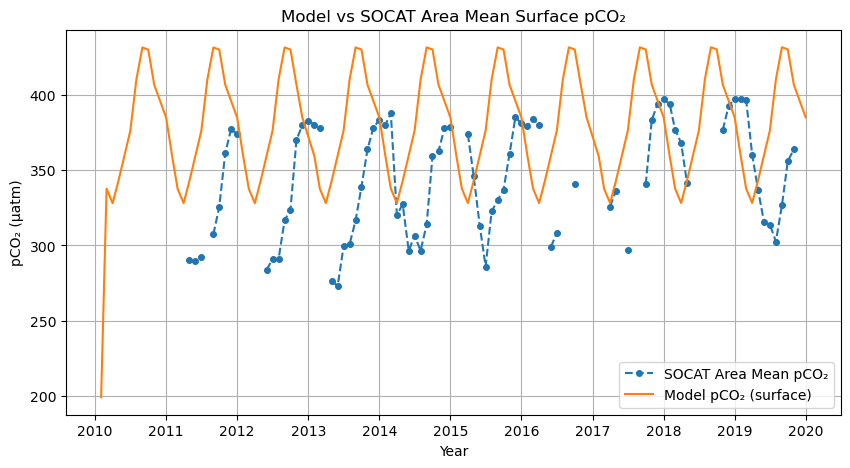

In [230]:
plt.figure(figsize=(10, 5))
plt.plot(obs_mean_df['date_obs'], obs_mean_df['pCO2_obs'], label='SOCAT Area Mean pCO₂', linestyle='--', marker='o', markersize=4)
plt.plot(df['date'], df['pCO2_surf'], label='Model pCO₂ (surface)')
plt.scatter(obs_mean_df['date_obs'], obs_mean_df['pCO2_obs'], s=10, color='red')
plt.xlabel('Year')
plt.ylabel('pCO₂ (µatm)')
plt.title('Model vs SOCAT Area Mean Surface pCO₂')
plt.grid(True)
plt.legend()
plt.savefig(imgDir + "GB_model_vs_SOCAT_pCO2.png", dpi=300)
plt.show()


# Glodap data

In [181]:
df_glodap = pd.read_csv(rawDir + "GLODAPv2.2023_Merged_Master_File.csv", low_memory=False)


In [257]:
# Basic structure
print(df_glodap.shape)             # Number of rows and columns
print(df_glodap.columns.tolist())  # List of column names

# set all -9999 to NaN
df_glodap.replace(-9999, np.nan, inplace=True)

(1402829, 109)
['G2expocode', 'G2cruise', 'G2station', 'G2region', 'G2cast', 'G2year', 'G2month', 'G2day', 'G2hour', 'G2minute', 'G2latitude', 'G2longitude', 'G2bottomdepth', 'G2maxsampdepth', 'G2bottle', 'G2pressure', 'G2depth', 'G2temperature', 'G2theta', 'G2salinity', 'G2salinityf', 'G2salinityqc', 'G2sigma0', 'G2sigma1', 'G2sigma2', 'G2sigma3', 'G2sigma4', 'G2gamma', 'G2oxygen', 'G2oxygenf', 'G2oxygenqc', 'G2aou', 'G2aouf', 'G2nitrate', 'G2nitratef', 'G2nitrateqc', 'G2nitrite', 'G2nitritef', 'G2silicate', 'G2silicatef', 'G2silicateqc', 'G2phosphate', 'G2phosphatef', 'G2phosphateqc', 'G2tco2', 'G2tco2f', 'G2tco2qc', 'G2talk', 'G2talkf', 'G2talkqc', 'G2fco2', 'G2fco2f', 'G2fco2temp', 'G2phts25p0', 'G2phts25p0f', 'G2phtsinsitutp', 'G2phtsinsitutpf', 'G2phtsqc', 'G2cfc11', 'G2pcfc11', 'G2cfc11f', 'G2cfc11qc', 'G2cfc12', 'G2pcfc12', 'G2cfc12f', 'G2cfc12qc', 'G2cfc113', 'G2pcfc113', 'G2cfc113f', 'G2cfc113qc', 'G2ccl4', 'G2pccl4', 'G2ccl4f', 'G2ccl4qc', 'G2sf6', 'G2psf6', 'G2sf6f', 'G2sf6

In [258]:
df_filtered = df_glodap[
    (df_glodap['G2latitude'].between(lat_min, lat_max)) &
    (df_glodap['G2longitude'].between(lon_min, lon_max)) &
    (df_glodap['G2year'] >= year_min) &
    (df_glodap['G2year'] <= year_max)
]

In [259]:
# Surface and deep cutoffs (example: ≤10 m = surface, >200 m = deep)
surface_depth_max = params['h1']  # 25 m
deep_depth_min = params['h1']  # 25 m
deep_depth_max = params['h2']  # 45 m	

# Surface layer (≤ 25 m)
df_surface = df_filtered[df_filtered['G2depth'] <= surface_depth_max]

# Deep layer (25–45 m)
df_deep = df_filtered[
    (df_filtered['G2depth'] > deep_depth_min) &
    (df_filtered['G2depth'] <= deep_depth_max)
]
vars_of_interest = ['G2year', 'G2month',
                    'G2temperature', 'G2salinity', 'G2tco2',
                    'G2talk', 'G2fco2', 'G2phts25p0']

df_surface = df_surface[vars_of_interest].copy()
df_deep = df_deep[vars_of_interest].copy()

In [260]:
# Combine year + month into a proper datetime column (we'll use 15th of the month)
df_surface['date'] = pd.to_datetime(dict(year=df_surface['G2year'], month=df_surface['G2month'], day=1))
df_deep['date'] = pd.to_datetime(dict(year=df_deep['G2year'], month=df_deep['G2month'], day=1))


df_surface_monthly = df_surface.groupby('date').mean(numeric_only=True).reset_index()
df_deep_monthly = df_deep.groupby('date').mean(numeric_only=True).reset_index()

vars_of_interest = ['date', 
                    'G2temperature', 'G2salinity', 'G2tco2',
                    'G2talk', 'G2fco2', 'G2phts25p0']

df_surface_monthly = df_surface_monthly[vars_of_interest].copy()
df_deep_monthly  = df_deep_monthly [vars_of_interest].copy()

# Rename for consistency
df_surface_monthly = df_surface_monthly.rename(columns={
    'date': 'date_obs',
    'G2temperature': 'T1_obs',
    'G2salinity': 'S1_obs',
    'G2tco2': 'DIC1_obs',
    'G2talk': 'TA1_obs',
    'G2fco2': 'pCO2_obs',
    'G2phts25p0': 'pH_obs'
})

df_deep_monthly = df_deep_monthly.rename(columns={
    'date': 'date_obs',
    'G2temperature': 'T2_obs',
    'G2salinity': 'S2_obs',
    'G2tco2': 'DIC2_obs',
    'G2talk': 'TA2_obs',
    'G2fco2': 'pCO2_obs',
    'G2phts25p0': 'pH_obs'
})


print("Surface Data Sample:\n", df_surface_monthly.head())
print("Deep Data Sample:\n", df_deep_monthly.head())

Surface Data Sample:
     date_obs     T1_obs     S1_obs     DIC1_obs      TA1_obs  pCO2_obs  pH_obs
0 2010-01-01   8.126667  35.288000  2142.323333  2325.083333       NaN     NaN
1 2010-02-01   7.450000  35.275000  2144.693333  2327.710000       NaN     NaN
2 2010-05-01   8.913333  35.244667  2118.643333  2329.203333       NaN     NaN
3 2010-08-01  12.013333  35.152333  2068.393333  2322.826667       NaN     NaN
4 2010-10-01  10.880000  35.085667  2090.826667  2322.506667       NaN     NaN
Deep Data Sample:
     date_obs  T2_obs  S2_obs  DIC2_obs  TA2_obs  pCO2_obs  pH_obs
0 2010-01-01    8.13  35.288   2142.26  2325.78       NaN     NaN
1 2010-02-01    7.45  35.275   2146.90  2330.61       NaN     NaN
2 2010-05-01    7.97  35.275   2146.20  2332.20       NaN     NaN
3 2010-08-01   11.67  35.161   2081.40  2323.45       NaN     NaN
4 2010-10-01   10.89  35.083   2092.01  2322.64       NaN     NaN


In [261]:
def plot_model_vs_glodap(model_df, obs_df, var_model, var_obs,
                         title=None):
    plt.figure(figsize=(12, 4))

    # Plot GLODAP observational data
    plt.plot(obs_df['date_obs'], obs_df[var_obs], label=f'GLODAP: {var_obs}', linestyle='--', marker='o', markersize=4)

    # Plot model data
    plt.plot(model_df['date'], model_df[var_model], label=f'Model: {var_model}')

    # Title and labels
    plot_title = title
    plt.title(plot_title)
    plt.xlabel("Year")
    plt.ylabel(var_model.replace('_', ' '))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


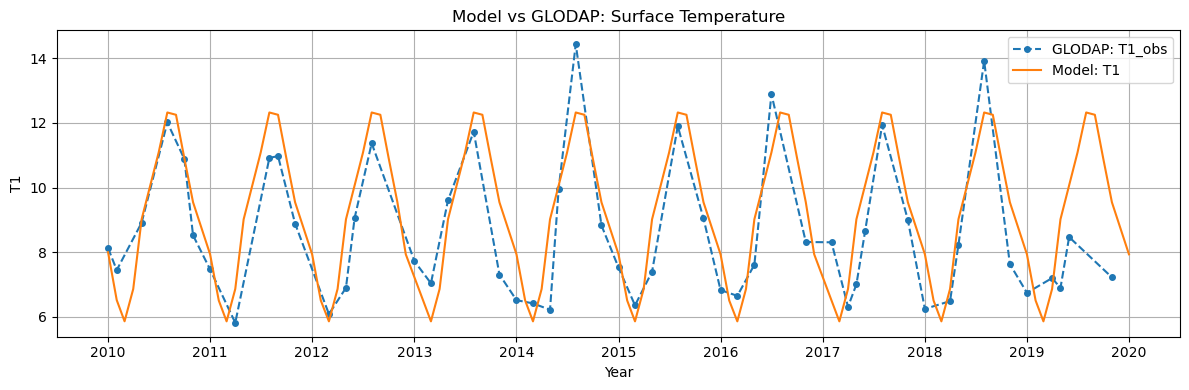

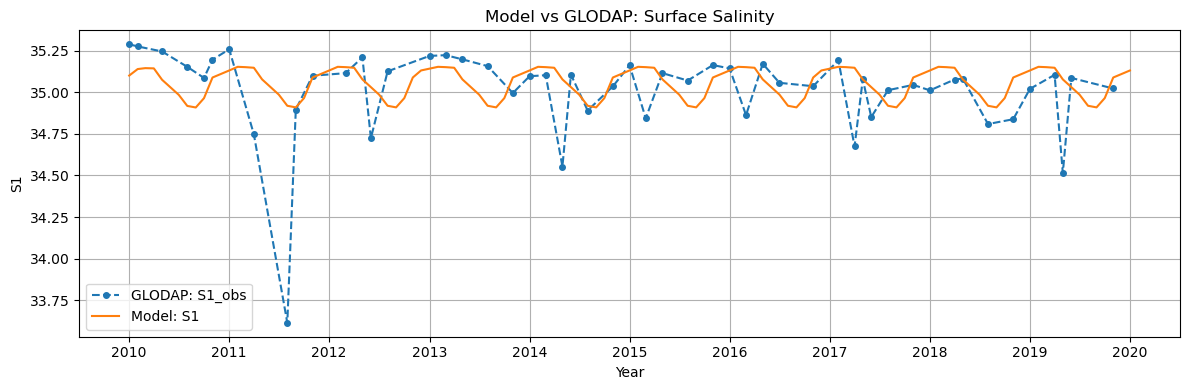

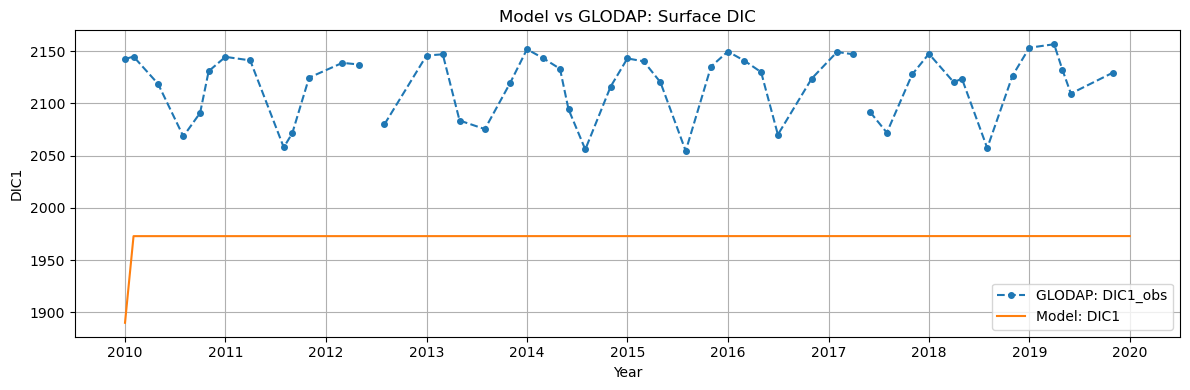

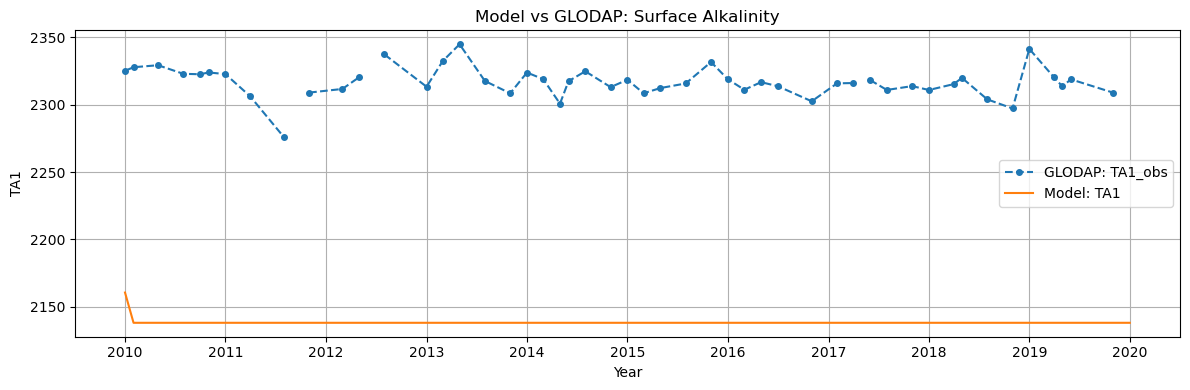

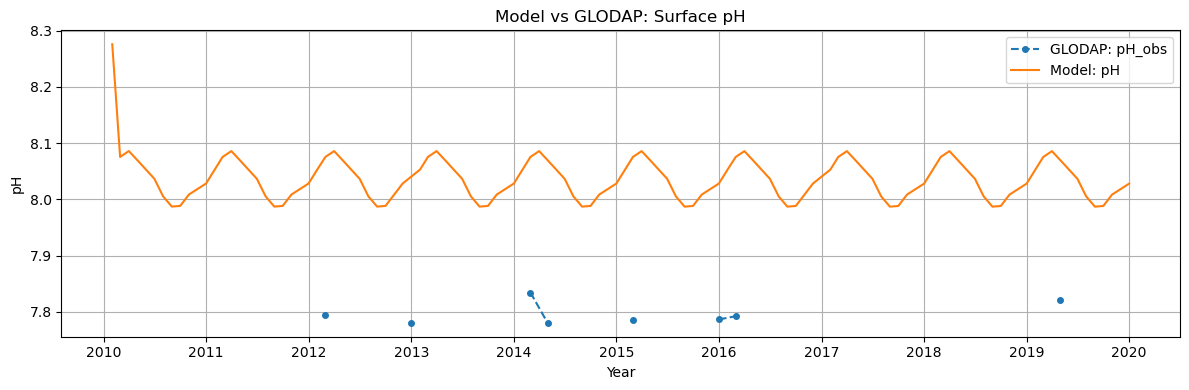

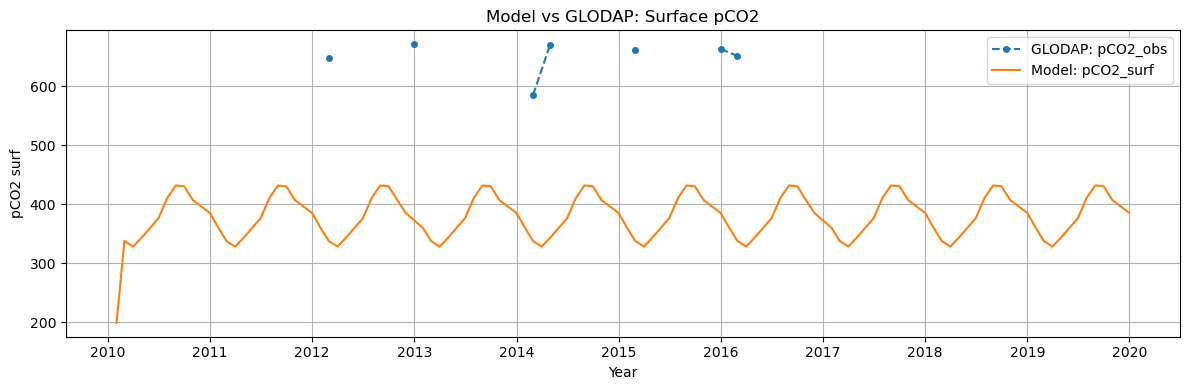

In [ ]:
plot_model_vs_glodap(
    model_df=df,
    obs_df=df_surface_monthly,
    var_model='T1',         # model variable name in df
    var_obs='T1_obs',        # GLODAP variable name in df_surface_monthly
    title='Model vs GLODAP: Surface Temperature'
)

plot_model_vs_glodap(
    model_df=df,
    obs_df=df_surface_monthly,
    var_model='S1',         # model variable name in df
    var_obs='S1_obs',        # GLODAP variable name in df_surface_monthly
    title='Model vs GLODAP: Surface Salinity'
)

plot_model_vs_glodap(
    model_df=df,
    obs_df=df_surface_monthly,
    var_model='DIC1',         # model variable name in df
    var_obs='DIC1_obs',        # GLODAP variable name in df_surface_monthly
    title='Model vs GLODAP: Surface DIC'
)

plot_model_vs_glodap(
    model_df=df,
    obs_df=df_surface_monthly,
    var_model='TA1',         # model variable name in df
    var_obs='TA1_obs',        # GLODAP variable name in df_surface_monthly
    title='Model vs GLODAP: Surface Alkalinity'
)

plot_model_vs_glodap(
    model_df=df,
    obs_df=df_surface_monthly,
    var_model='pH',         # model variable name in df
    var_obs='pH_obs',        # GLODAP variable name in df_surface_monthly
    title='Model vs GLODAP: Surface pH'
)

plot_model_vs_glodap(
    model_df=df,
    obs_df=df_surface_monthly,
    var_model='pCO2_surf',         # model variable name in df
    var_obs='pCO2_obs',        # GLODAP variable name in df_surface_monthly
    title='Model vs GLODAP: Surface pCO2'
)

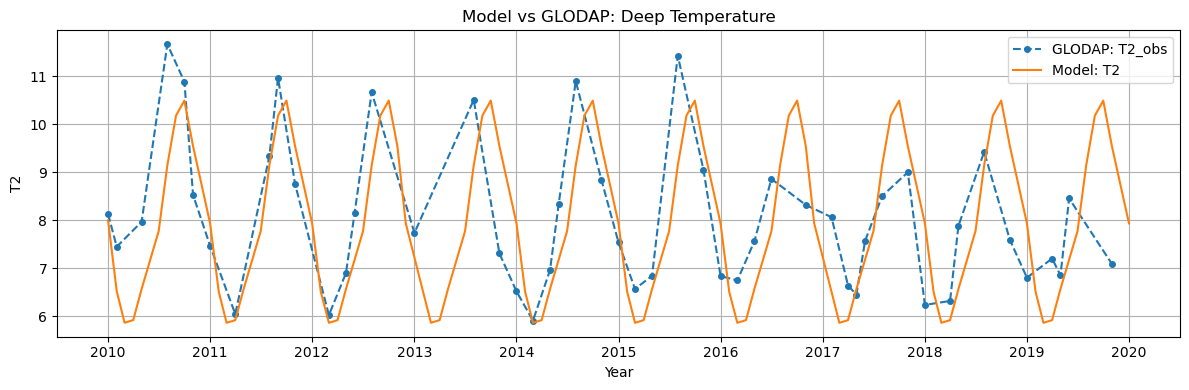

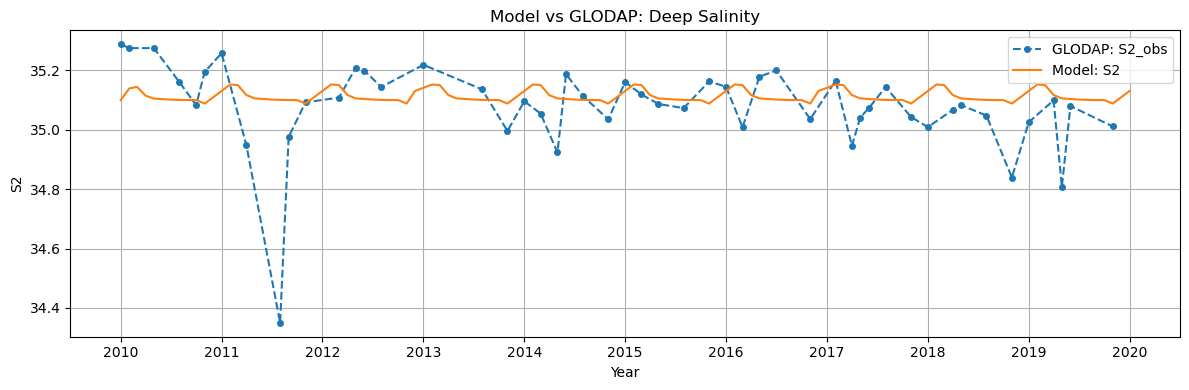

In [263]:
plot_model_vs_glodap(
    model_df=df,
    obs_df=df_deep_monthly,
    var_model='T2',         # model variable name in df
    var_obs='T2_obs',        # GLODAP variable name in df_surface_monthly
    title='Model vs GLODAP: Deep Temperature'
)

plot_model_vs_glodap(
    model_df=df,
    obs_df=df_deep_monthly,
    var_model='S2',         # model variable name in df
    var_obs='S2_obs',        # GLODAP variable name in df_surface_monthly
    title='Model vs GLODAP: Deep Salinity'
)

## Unconstrained optimization

## Model as function

In [ ]:
def run_model_with_params(param_values, param_names, fixed_params, initial_state, times, NCP, pCO2_atm, K_air, delta_z):
    # Update params with values to optimize
    p = fixed_params.copy()
    for name, val in zip(param_names, param_values):
        p[name] = val

    state = initial_state.copy()
    states = [state.copy()]

    for t in times[1:]:
        T1, T2, S1, S2, DIC1, DIC2, TA1, TA2 = state

        seasonal_T1 = p['A_1T'] * np.cos(2 * np.pi * t + p['phi_1T'])
        seasonal_T2 = p['A_2T'] * np.cos(2 * np.pi * t + p['phi_2T'])
        seasonal_S1 = p['A_1S'] * np.cos(2 * np.pi * t + p['phi_1S'])

        dT1 = (p['T1_star'] - seasonal_T1 - T1) / p['tau_1T']
        dT2 = (p['T2_star'] - seasonal_T2 - T2) / p['tau_2']
        dS1 = (p['S1_star'] - seasonal_S1 - S1) / p['tau_1S']
        dS2 = (p['S2_star'] - S2) / p['tau_2']

        co2sys_result = pyco2.sys(
            par1=TA1, par2=DIC1,
            par1_type=1, par2_type=2,
            salinity=S1, temperature=T1, pressure=0,
            total_silicate=0.0, total_phosphate=0.0,
            opt_k_carbonic=4, opt_k_bisulfate=1)

        alpha_CO2 = co2sys_result['k_CO2']
        pCO2_surf = co2sys_result['pCO2']
        J_air = K_air * alpha_CO2 * (pCO2_atm - pCO2_surf)

        dDIC1 = (J_air + p['KD'] * ((DIC2 - DIC1) / delta_z) - NCP * (1 + p['PICPOC'])) / p['h1']
        dDIC2 = (p['Remin'] * NCP + NCP * p['PICPOC'] - p['KD'] * ((DIC2 - DIC1) / delta_z)) / p['h2']
        dTA1 = (p['KD'] * ((TA2 - TA1) / delta_z) - 2 * NCP * p['PICPOC']) / p['h1']
        dTA2 = (-p['KD'] * ((TA2 - TA1) / delta_z) + 2 * NCP * p['PICPOC']) / p['h2']

        dt = times[1] - times[0]
        T1_hat = T1 + dt * dT1
        T2_hat = T2 + dt * dT2
        S1_hat = S1 + dt * dS1
        S2_hat = S2 + dt * dS2
        DIC1_hat = DIC1 + dt * dDIC1
        DIC2_hat = DIC2 + dt * dDIC2
        TA1_hat = TA1 + dt * dTA1
        TA2_hat = TA2 + dt * dTA2

        def density(T, S):
            rho0 = 1025
            alpha = 0.2
            beta = 0.8
            return rho0 * (1 - alpha * (T - 10) + beta * (S - 35))

        if density(T1_hat, S1_hat) > density(T2_hat, S2_hat):
            mix_T = (p['h1'] * T1_hat + p['h2'] * T2_hat) / (p['h1'] + p['h2'])
            mix_S = (p['h1'] * S1_hat + p['h2'] * S2_hat) / (p['h1'] + p['h2'])
            mix_DIC = (p['h1'] * DIC1_hat + p['h2'] * DIC2_hat) / (p['h1'] + p['h2'])
            mix_TA = (p['h1'] * TA1_hat + p['h2'] * TA2_hat) / (p['h1'] + p['h2'])
            state = np.array([mix_T, mix_T, mix_S, mix_S, mix_DIC, mix_DIC, mix_TA, mix_TA])
        else:
            state = np.array([T1_hat, T2_hat, S1_hat, S2_hat, DIC1_hat, DIC2_hat, TA1_hat, TA2_hat])

        states.append(state.copy())

    df = pd.DataFrame(states, columns=['T1', 'T2', 'S1', 'S2', 'DIC1', 'DIC2', 'TA1', 'TA2'])
    df['time'] = times
    # Base time for your model (e.g. Jan 1, 2010)
    start_year = datetime(2010, 1, 1)
    # Convert model time in fractional years to actual dates
    df['date'] = pd.to_datetime(df['time'] * 365.25, unit='D', origin=start_year)
    df['date'] = df['date'].dt.to_period('M').dt.to_timestamp()
    return df[['date', 'T1', 'T2', 'S1', 'S2']]

## Surface Temperature optimization with SOCAT/Glodap data

In [214]:
# Parameters we want to optimize
param_names = ['T1_star', 'tau_1T', 'A_1T']

def cost_function(param_values):
    print("Evaluating cost at:", param_values)

    # Run model with given parameter values
    model_df = run_model_with_params(
        param_values=param_values,
        param_names=param_names,
        fixed_params=params,
        initial_state=initial_state,
        times=times,
        NCP=NCP,
        pCO2_atm=pCO2_atm,
        K_air=K_air,
        delta_z=delta_z
    )

    if model_df[['T1']].isna().any().any():
        return np.inf


    # Merge with monthly mean observational data
    merged = pd.merge(model_df, df_surface_monthly, left_on='date', right_on='date_obs', how='inner') # either socat or glodap data

    # Mean Squared Error (used for optimization)
    cost = np.mean((merged['T1'] - merged['T1_obs'])**2)

    bias = np.mean(merged['T1'] - merged['T1_obs'])
    rmse = np.sqrt(cost)
    print(f"Bias: {bias:.2f}, RMSE: {rmse:.2f}")

    # Total cost
    return cost


In [215]:
# Initial guess for the parameters you want to optimize
initial_guess = [params[name] for name in param_names]

# Example bounds (adjust based on your model domain)
bounds = [
    (5, 15),     # T1_star: surface target temperature in °C
    (0.05, 5),   # tau_1T: positive timescale in years
    (0.0, 5.0)   # A_1T: seasonal amplitude in °C
]

result = minimize(cost_function,
                  x0=initial_guess,
                  method='L-BFGS-B',
                  bounds=bounds,
                  options={
                      'disp': True,
                      'maxiter': 10,
                      'gtol': 1e-1,
                      'ftol': 1e-1,
                      'eps': 1e-1
                  })


Evaluating cost at: [8.9  0.09 3.5 ]
Bias: 0.54, RMSE: 1.27
Evaluating cost at: [9.   0.09 3.5 ]
Bias: 0.61, RMSE: 1.31
Evaluating cost at: [8.9  0.19 3.5 ]
Bias: 0.26, RMSE: 1.49
Evaluating cost at: [8.9  0.09 3.6 ]
Bias: 0.54, RMSE: 1.28
Evaluating cost at: [8.07539793 0.05       3.43411877]
Bias: -0.06, RMSE: 1.29
Evaluating cost at: [8.17539793 0.05       3.43411877]
Bias: 0.01, RMSE: 1.29
Evaluating cost at: [8.07539793 0.15       3.43411877]
Bias: -0.18, RMSE: 1.43
Evaluating cost at: [8.07539793 0.05       3.53411877]
Bias: -0.04, RMSE: 1.31
Evaluating cost at: [8.67093834 0.07888862 3.48169922]
Bias: 0.40, RMSE: 1.25
Evaluating cost at: [8.77093834 0.07888862 3.48169922]
Bias: 0.47, RMSE: 1.27
Evaluating cost at: [8.67093834 0.17888862 3.48169922]
Bias: 0.13, RMSE: 1.45
Evaluating cost at: [8.67093834 0.07888862 3.58169922]
Bias: 0.41, RMSE: 1.25


In [216]:
# Output
print(result.message)
print("Converged:", result.success)

best_params = {k: v for k, v in zip(param_names, result.x)}
print("Best-fit parameters:", best_params)
print("Final cost:", result.fun)

CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
Converged: True
Best-fit parameters: {'T1_star': np.float64(8.670938342707734), 'tau_1T': np.float64(0.078888620742423), 'A_1T': np.float64(3.4816992153425614)}
Final cost: 1.552211749030037


In [210]:
# Output
print(result.message)
print("Converged:", result.success)

best_params = {k: v for k, v in zip(param_names, result.x)}
print("Best-fit parameters:", best_params)
print("Final cost:", result.fun)

CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
Converged: True
Best-fit parameters: {'T1_star': np.float64(8.225527462930058), 'tau_1T': np.float64(0.05), 'A_1T': np.float64(3.281888223380785)}
Final cost: 1.0811246097806502


## Plot Optimization Results

In [ ]:
# Use the best-fit values from the optimizer
optimized_params = result.x  


# Run model with optimized parameters
model_df_opt = run_model_with_params(
    param_values=optimized_params,
    param_names=param_names,
    fixed_params=params,
    initial_state=initial_state,
    times=times,
    NCP=NCP,
    pCO2_atm=pCO2_atm,
    K_air=K_air,
    delta_z=delta_z
)

In [220]:
# Merge
plot_df = pd.merge(model_df_opt, df_surface_monthly, left_on='date', right_on='date_obs', how='inner')

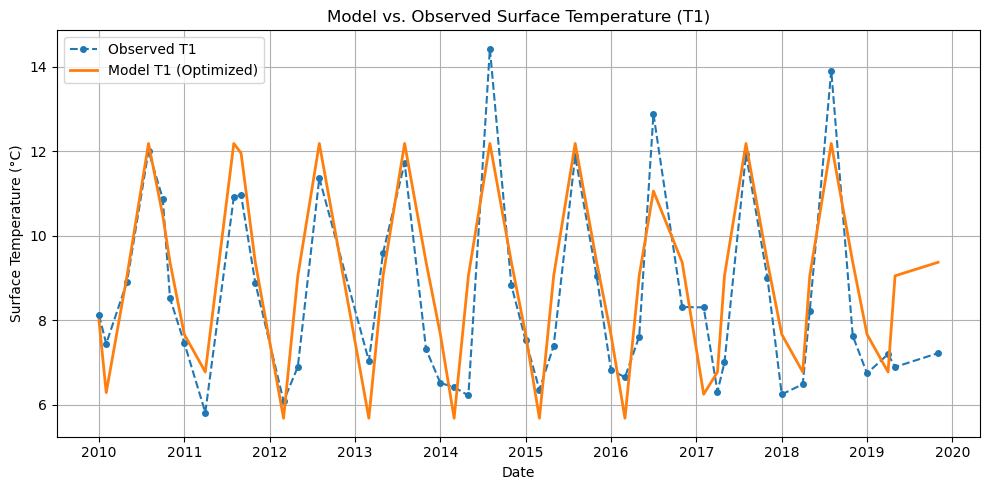

In [221]:
plt.figure(figsize=(10, 5))
plt.plot(plot_df['date'], plot_df['T1_obs'], label='Observed T1', linestyle='--', marker='o', markersize=4)
plt.plot(plot_df['date'], plot_df['T1'], label='Model T1 (Optimized)', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Surface Temperature (°C)')
plt.title('Model vs. Observed Surface Temperature (T1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


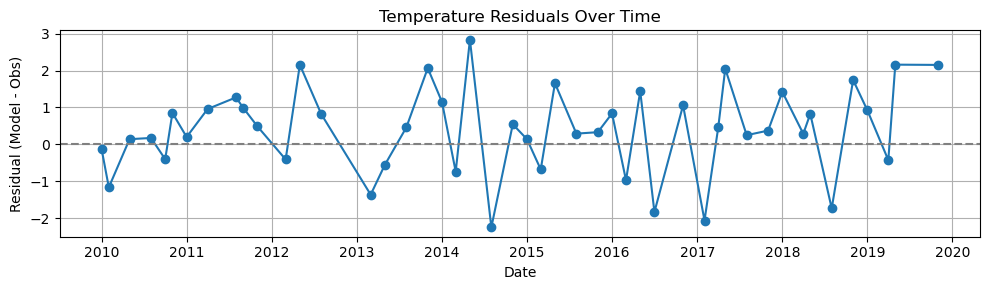

In [222]:
plt.figure(figsize=(10, 3))
residuals = plot_df['T1'] - plot_df['T1_obs']
plt.plot(plot_df['date'], residuals, marker='o')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residual (Model - Obs)')
plt.title('Temperature Residuals Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()


## Optimizing Temperature and Salinity upper and lower layer with Glodap data

In [241]:
param_names = [
    'T1_star', 'T2_star',     # restoring temps
    'S1_star',                # restoring salinity
    'tau_1T', 'tau_1S', 'tau_2',  # restoring timescales
    'A_1T', 'A_2T', 'A_1S',       # seasonal amplitudes
    'phi_1T', 'phi_2T', 'phi_1S'  # seasonal phases
]


In [242]:
def cost_function(param_values):
    print("Evaluating cost at:", param_values)

    # Run the model
    model_df = run_model_with_params(
        param_values=param_values,
        param_names=param_names,
        fixed_params=params,
        initial_state=initial_state,
        times=times,
        NCP=NCP,
        pCO2_atm=pCO2_atm,
        K_air=K_air,
        delta_z=delta_z
    )

    if model_df[['T1', 'T2', 'S1']].isna().any().any():
        print("Model produced NaNs — returning infinite cost")
        return np.inf

    # Merge model output with observations
    surface_merged = pd.merge(model_df, df_surface_monthly, left_on='date', right_on='date_obs', how='inner')
    deep_merged    = pd.merge(model_df, df_deep_monthly,    left_on='date', right_on='date_obs', how='inner')

    # Compute mean squared error for temperature and salinity
    cost_T1 = np.mean((surface_merged['T1'] - surface_merged['T1_obs'])**2)
    cost_S1 = np.mean((surface_merged['S1'] - surface_merged['S1_obs'])**2)
    cost_T2 = np.mean((deep_merged['T2'] - deep_merged['T2_obs'])**2)

    
    # Weighted cost (as in the paper)
    tec = 0.2  # thermal expansion
    hcc = 0.8  # haline contraction
    total_cost = tec * (cost_T1 + cost_T2) + hcc * cost_S1

    # Print diagnostics
    bias_T1 = np.mean(surface_merged['T1'] - surface_merged['T1_obs'])
    bias_S1 = np.mean(surface_merged['S1'] - surface_merged['S1_obs'])
    bias_T2 = np.mean(deep_merged['T2'] - deep_merged['T2_obs'])
    print(f"Bias T1: {bias_T1:.2f}, Bias T2: {bias_T2:.2f}, Bias S2: {bias_S1:.2f} Total cost: {total_cost:.3f}")

    return total_cost


In [243]:
# Initial guess for the parameters you want to optimize
initial_guess = [params[name] for name in param_names]

# Example bounds (adjust based on your model domain)
bounds = [
    (6, 11),     # T1_star (°C)
    (7, 10),     # T2_star (°C)

    (34.75, 35.25),    # S1_star (PSU)

    (0.05, 1),    # tau_1T (years)
    (0.05, 1),    # tau_1S (years)
    (0.05, 1),   # tau_2 (years, deeper can be slower)

    (0.0, 5),    # A_1T (seasonal temp amplitude, °C)
    (0.0, 5),    # A_2T
    (-1, 1),  # A_1S (salinity varies less seasonally)

    (-2, 2),  # phi_1T (phase in radians)
    (-2, 2),  # phi_2T
    (-2, 2)   # phi_1S
]


result = minimize(cost_function,
                  x0=initial_guess,
                  method='L-BFGS-B',
                  bounds=bounds,
                  options={
                      'disp': True,
                      'maxiter': 20,
                      'gtol': 1e-1,
                      'ftol': 1e-1,
                      'eps': 1e-1
                  })


Evaluating cost at: [ 8.9   8.3  35.1   0.09  0.27  0.15  3.5   2.5  -0.3  -0.97 -1.54 -0.45]
Bias T1: 0.54, Bias T2: -0.13, Bias S2: 0.05 Total cost: 0.649
Evaluating cost at: [ 9.    8.3  35.1   0.09  0.27  0.15  3.5   2.5  -0.3  -0.97 -1.54 -0.45]
Bias T1: 0.61, Bias T2: -0.11, Bias S2: 0.05 Total cost: 0.670
Evaluating cost at: [ 8.9   8.4  35.1   0.09  0.27  0.15  3.5   2.5  -0.3  -0.97 -1.54 -0.45]
Bias T1: 0.56, Bias T2: -0.05, Bias S2: 0.05 Total cost: 0.649
Evaluating cost at: [ 8.9   8.3  35.2   0.09  0.27  0.15  3.5   2.5  -0.3  -0.97 -1.54 -0.45]
Bias T1: 0.54, Bias T2: -0.13, Bias S2: 0.11 Total cost: 0.657
Evaluating cost at: [ 8.9   8.3  35.1   0.19  0.27  0.15  3.5   2.5  -0.3  -0.97 -1.54 -0.45]
Bias T1: 0.26, Bias T2: 0.15, Bias S2: 0.05 Total cost: 0.855
Evaluating cost at: [ 8.9   8.3  35.1   0.09  0.37  0.15  3.5   2.5  -0.3  -0.97 -1.54 -0.45]
Bias T1: 0.54, Bias T2: -0.13, Bias S2: 0.06 Total cost: 0.650
Evaluating cost at: [ 8.9   8.3  35.1   0.09  0.27  0.25  3

In [244]:
# Output
print(result.message)
print("Converged:", result.success)

best_params = {k: v for k, v in zip(param_names, result.x)}
print("Best-fit parameters:", best_params)
print("Final cost:", result.fun)## Plot Optimization Results
# Use the best-fit values from the optimizer
optimized_params = result.x  

CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
Converged: True
Best-fit parameters: {'T1_star': np.float64(8.725810644899303), 'T2_star': np.float64(8.292875398993766), 'S1_star': np.float64(35.033530177854324), 'tau_1T': np.float64(0.05838856824418267), 'tau_1S': np.float64(0.26440604271516727), 'tau_2': np.float64(0.07097142061045666), 'A_1T': np.float64(3.4432797419943815), 'A_2T': np.float64(2.3860422524387177), 'A_1S': np.float64(-0.30569520694010616), 'phi_1T': np.float64(-1.2436453601370554), 'phi_2T': np.float64(-1.2982703973552239), 'phi_1S': np.float64(-0.44327085009659484)}
Final cost: 0.4720674416728767


In [ ]:
# Run model with optimized parameters
model_df_opt = run_model_with_params(
    param_values=optimized_params,
    param_names=param_names,
    fixed_params=params,
    initial_state=initial_state,
    times=times,
    NCP=NCP,
    pCO2_atm=pCO2_atm,
    K_air=K_air,
    delta_z=delta_z
)


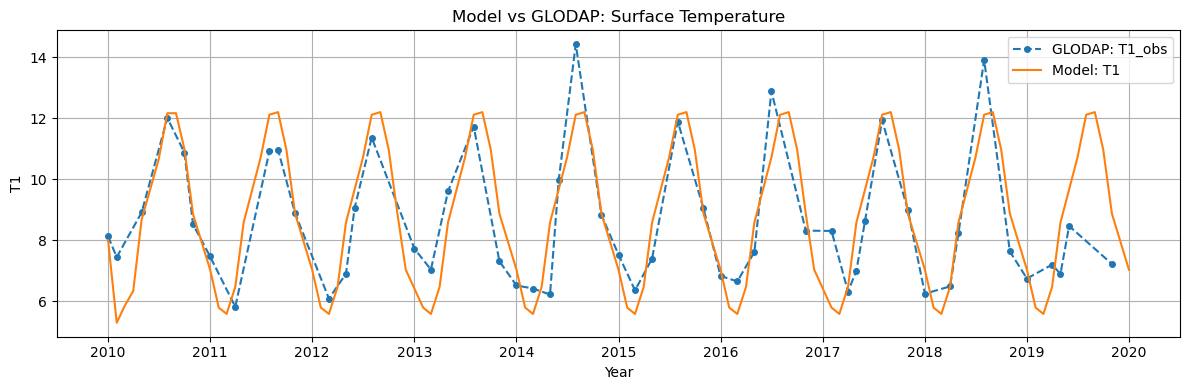

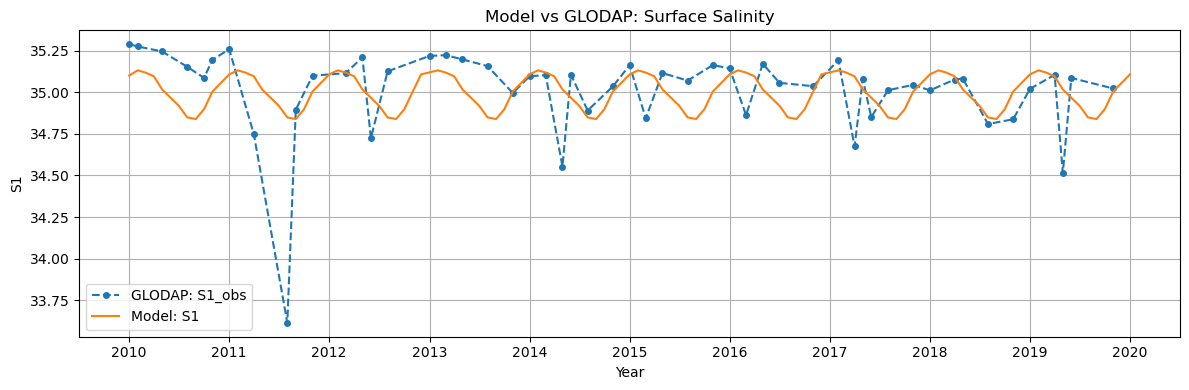

In [265]:
plot_model_vs_glodap(
    model_df=model_df_opt,
    obs_df=df_surface_monthly,
    var_model='T1',         # model variable name in df
    var_obs='T1_obs',        # GLODAP variable name in df_surface_monthly
    title='Model vs GLODAP: Surface Temperature'
)

plot_model_vs_glodap(
    model_df=model_df_opt,
    obs_df=df_surface_monthly,
    var_model='S1',         # model variable name in df
    var_obs='S1_obs',        # GLODAP variable name in df_surface_monthly
    title='Model vs GLODAP: Surface Salinity'
)


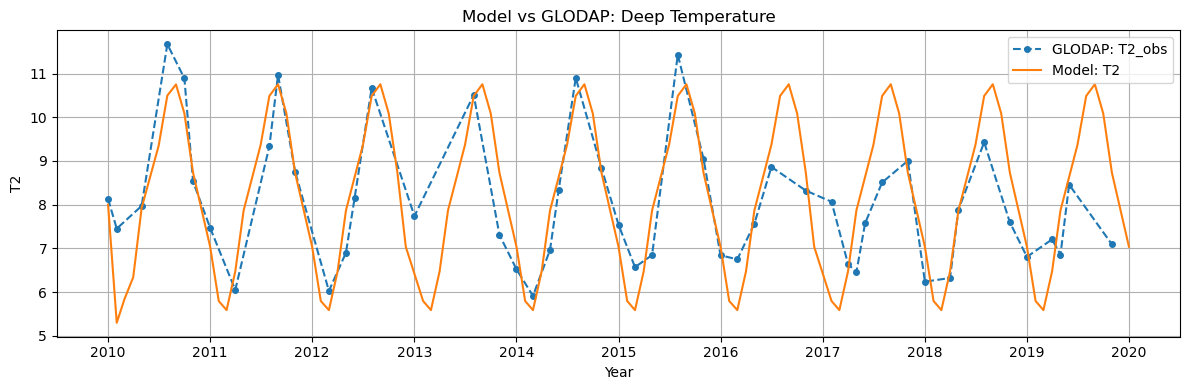

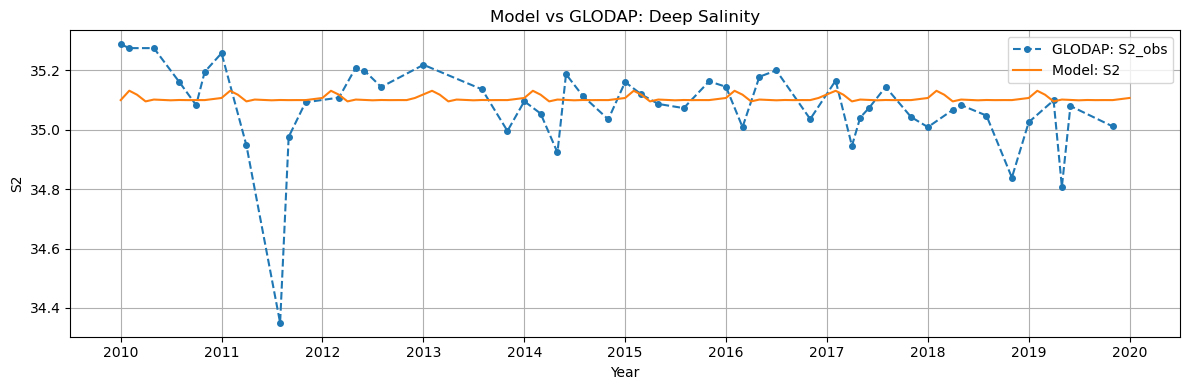

In [266]:
plot_model_vs_glodap(
    model_df=model_df_opt,
    obs_df=df_deep_monthly,
    var_model='T2',         # model variable name in df
    var_obs='T2_obs',        # GLODAP variable name in df_surface_monthly
    title='Model vs GLODAP: Deep Temperature'
)

plot_model_vs_glodap(
    model_df=model_df_opt,
    obs_df=df_deep_monthly,
    var_model='S2',         # model variable name in df
    var_obs='S2_obs',        # GLODAP variable name in df_surface_monthly
    title='Model vs GLODAP: Deep Salinity'
)